In [ ]:
spark.stop()

In [1]:
import pyspark
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpt
from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row
from graphframes import *
from delta import *
from delta.tables import *

from pyspark.sql.functions import col, hex, base64, avg, collect_list, concat, lit, max
from pyspark.sql.types import StringType,BooleanType,DateType

In [2]:
config = pyspark.SparkConf().setAll([
    ('spark.executor.memory', '12g'), 
    ('spark.executor.cores', '3'), 
    ('spark.cores.max', '3'),
    ('spark.driver.memory','1g'),
    ('spark.executor.instances', '1'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.shuffleTracking.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '60s'),
    ('spark.dynamicAllocation.minExecutors', '0'),
    ('spark.dynamicAllocation.maxExecutors', '2'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.executorAllocationRatio', '1')
])

In [3]:
builder = pyspark.sql.SparkSession.builder \
    .appName("NetworkQueries") \
    .master("spark://172.23.149.212:7077") \
    .config(conf=config) \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

22/05/13 06:41:19 WARN Utils: Your hostname, algorand-druid-and-spark resolves to a loopback address: 127.0.0.1; using 172.23.149.212 instead (on interface ens3)
22/05/13 06:41:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bfa3115f-8823-420a-83e8-8a48f989a09c;1.0
	confs: [default]
	found io.delta#delta-core_2.12;1.1.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 217ms :: artifacts dl 6ms
	:: modules in use:
	io.delta#delta-core_2.12;1.1.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      d

In [4]:
# account table to determine which accounts have received rewards
dfAccounts = spark.read.format("delta").load("/mnt/delta/bronze/algod.indexer.public.account")
dfAccounts = dfAccounts.drop("key", "account_data")
dfAccounts = dfAccounts.repartition(3)
dfAccounts.rdd.getNumPartitions()

# txn table to find all transactions between them
dfTxn = spark.read.format("delta").load("/mnt/delta/bronze/algod_indexer_public_txn_flat")
dfTxn = dfTxn.repartition(3)
dfTxn.rdd.getNumPartitions()


dfAccounts.show(5)
print(dfAccounts.dtypes)
print(dfAccounts.count())
dfTxn.show(1, vertical=True, truncate=False)
print(dfTxn.dtypes)
print(dfTxn.count())

+--------------------+----------+-----------+-------------+-------+----------+---------+-------+
|                addr|microalgos|rewardsbase|rewards_total|deleted|created_at|closed_at|keytype|
+--------------------+----------+-----------+-------------+-------+----------+---------+-------+
|7qaUbjOcWd6OCnz4F...|    199000|       3696|           20|  false|    187392|     null|    sig|
|JAVCEOIq4bmr5E5ew...|1303588555|     110049|      3038773|  false|   4998077|     null|   null|
|1ZpcKa7UcvAPCXOSM...|    199000|     106748|            0|  false|   5003839|     null|    sig|
|bn1Gf6dj+UxTu6xND...|    199000|      55732|            0|  false|   2777778|     null|    sig|
|cf/g4UYtXkfur0nRk...|    999250|       3395|          250|  false|    170422|     null|    sig|
+--------------------+----------+-----------+-------------+-------+----------+---------+-------+
only showing top 5 rows

[('addr', 'string'), ('microalgos', 'bigint'), ('rewardsbase', 'bigint'), ('rewards_total', 'bigint'),

22/05/13 06:42:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0---------------------------------------------------
 key         | null                                         
 ROUND       | 4781493                                      
 TXID        | null                                         
 INTRA       | 202                                          
 TYPEENUM    | 1                                            
 ASSET       | null                                         
 EXTRA       | {}                                           
 RR          | null                                         
 SIG         | null                                         
 TXN_FEE     | 1000                                         
 TXN_FV      | 4780900                                      
 TXN_GH      | wGHE2Pwdvd7S12BL5FaOP20EGYesN73ktiC1qzkkit8= 
 TXN_LV      | 4781900                                      
 TXN_SND     | pZkgofoRhGjs2K0Q628OZYjeg1aM5hP7GtqJtjqlids= 
 TXN_TYPE    | pay                                          
 TXN_GEN     | mainnet-v

### Miner selection and basic queries on it

In [5]:
dfMiners = dfAccounts.where((dfAccounts.rewards_total > 0) & (dfAccounts.deleted == False)).sort("rewards_total", ascending=False)
dfUsers = dfAccounts.where((dfAccounts.rewards_total == 0) & (dfAccounts.deleted == False))

dfMiners.show(5)
print("Number of Miners", dfMiners.count())
dfUsers.show(5)
print("Number of Users", dfUsers.count())

+--------------------+--------------+-----------+-------------+-------+----------+---------+-------+
|                addr|    microalgos|rewardsbase|rewards_total|deleted|created_at|closed_at|keytype|
+--------------------+--------------+-----------+-------------+-------+----------+---------+-------+
|FFYBgOnJLaMXGqPIc...|23213192022326|     112029|6769820186921|  false|     68239|     null|   msig|
|AgQ6O8TnsBTFbODKl...|53773440564744|     112026|5773426182744|  false|         0|     null|   msig|
|deyGTjkHZ1eAKS93w...|53686900450346|     110408|5686886068346|  false|         0|     null|   msig|
|Jh2WUWUuc9gMbLQ9w...|53572769241671|     108277|5572899146671|  false|         0|     null|   msig|
|9dJ9PSwF7S5ExPNDh...|53562653976981|     108085|5562639594981|  false|         0|     null|   msig|
+--------------------+--------------+-----------+-------------+-------+----------+---------+-------+
only showing top 5 rows

Number of Miners 18823
+--------------------+------------+--------

In [6]:
#average totalRewards
dfMiners.agg(avg(dfMiners.rewards_total)).show()

+--------------------+
|  avg(rewards_total)|
+--------------------+
|1.037640641217792...|
+--------------------+



In [7]:
dfAccounts.sort("microalgos", ascending=False).show(5)

+--------------------+----------------+-----------+-------------+-------+----------+---------+-------+
|                addr|      microalgos|rewardsbase|rewards_total|deleted|created_at|closed_at|keytype|
+--------------------+----------------+-----------+-------------+-------+----------+---------+-------+
|b0JrIkBMsT+yttBHO...|1515999999979000|          0|            0|  false|         0|     null|   msig|
|099ib9ijLUqgs66B6...| 483336753228673|          0|            0|  false|         0|     null|   msig|
|TE0TRtw+AtAA8fqgt...| 398095753837694|          0|            0|  false|         0|     null|   msig|
|BgJwG0MCHG16BK76d...| 300000000000000|          0|            0|  false|         0|     null|   null|
|BnSlAOXT0sISlW8Jp...| 300000000000000|          0|            0|  false|         0|     null|   null|
+--------------------+----------------+-----------+-------------+-------+----------+---------+-------+
only showing top 5 rows



Write the miners and users into the silver table of the delta lake

In [13]:
dfMiners.write.format("delta").mode("overwrite").save("/mnt/delta/silver/queries/network/miner.addresses")
dfUsers.write.format("delta").mode("overwrite").save("/mnt/delta/silver/queries/network/user.addresses")

### Community detection in transaction network

Start by building the graphframe by using the dfTxnTable

In [8]:
# prepare vertices dataframe
txnSenderDf = dfTxn.select(dfTxn.TXN_SND.alias("id"))
txnReceiverDf = dfTxn.select(dfTxn.TXN_RCV.alias("id"))
txnVerticesDf = txnSenderDf.union(txnReceiverDf).dropDuplicates().drop()
txnVerticesDf.show(5, False)

+--------------------------------------------+
|id                                          |
+--------------------------------------------+
|484SLprGESDH2QlZm+v1Rz+/Os/Ssa/KBoWaHchMNg0=|
|WIg43KcPGicJdwImyA/+OlpddpAC/8VXVjkLC0JJIfM=|
|bhApvaWML4fYv1GEEN861WixVHA3dGE+EPkcwLfMw1E=|
|BKQBsA2SYKSkgut1Cf11J4kkoqBwRjDCNMXBUffOcD8=|
|YyW+Y4LZ6ZFZpOVS2WUgBjJInV3P2qj7h5r2Jpk/HpQ=|
+--------------------------------------------+
only showing top 5 rows



In [9]:
# prepare edges dataframe
txnEdgesDf = dfTxn.select(dfTxn.TXN_SND.alias("src"), dfTxn.TXN_RCV.alias("dst"))
txnEdgesDf = txnEdgesDf.withColumn("relationship", lit("sent")).drop()
txnEdgesDf.show(5, False)

+--------------------------------------------+--------------------------------------------+------------+
|src                                         |dst                                         |relationship|
+--------------------------------------------+--------------------------------------------+------------+
|YrvdyixDPR+6nAZHhu8WG+3+B75fo74kdgEECaKcgaM=|xxoPFnTVw2VgRk9Gguf2FFxLCoMhpb8d54wpaCglmiM=|sent        |
|zVjs1ylXuNJgb6DMYXdNR47r6XSFUWwKE06GW8TPX/Q=|tvFOWud+p+BEQe3g/mSVlou3gHEDD3KesZ2ekH9z8dw=|sent        |
|6UcpsTGOUvbffCuRnQ344pAsllK98qUeo6b6LMEPMwY=|k//OpTHinxgS6cnqgjf78vE16noZWG25CCpDX3lf284=|sent        |
|peoH04okZMbRCx1zRSi8Uy0PxLKWH3xIhpYbhCxcKQ4=|kgYCINg20RUgLenpasz6/Oypk90qJmSB1xvScv/Bpaw=|sent        |
|zVjs1ylXuNJgb6DMYXdNR47r6XSFUWwKE06GW8TPX/Q=|foaC3Kp6WVxyDB88XaEbkYEYBfTkKOykvYCUZAjBEWw=|sent        |
+--------------------------------------------+--------------------------------------------+------------+
only showing top 5 rows



In [10]:
print("Size of vertices", txnVerticesDf.count())
print("Size of edges", txnEdgesDf.count())

# Create a GraphFrame
g = GraphFrame(txnVerticesDf, txnEdgesDf)

Size of vertices 28016
Size of edges 1137637


In [11]:
# Get a DataFrame with columns "id" and "inDegree" (in-degree)
g.inDegrees.sort("inDegree", ascending=False).show(5)
g.outDegrees.sort("outDegree", ascending=False).show(5)

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|k//OpTHinxgS6cnqg...|   53462|
|tqdYqmfAfnHWhkeJ4...|   26204|
|TwBENFKSxg+toW2Zz...|   17971|
|FFYBgOnJLaMXGqPIc...|   12733|
|RvfOlpCGjRCcuYPXi...|   11714|
+--------------------+--------+
only showing top 5 rows



+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|7OUGoX3hg950O7LF5...|   671808|
|k//OpTHinxgS6cnqg...|    51777|
|akS19o9GVXmeHNM7o...|    31677|
|DVhKTLv9mkh42BZRK...|    19713|
|TwBENFKSxg+toW2Zz...|    17772|
+--------------------+---------+
only showing top 5 rows



Use label propagation to detect communities inside the graphframe

In [12]:
communitiesDf = g.labelPropagation(maxIter=5)

In [ ]:
# TODO create graph showing at which iteration we have reached our minimum of communities

Group all nodes having the same label into one community

In [13]:
commsDfCount = communitiesDf.groupBy("label").count()
commsDfCount.sort("count", ascending=False).show(5)
print("Number of communities", commsDfCount.count())

+-------------+-----+
|        label|count|
+-------------+-----+
| 790273982578|13756|
|1520418422853| 1758|
|  94489280589| 1359|
|1640677507173| 1323|
| 498216206387|  859|
+-------------+-----+
only showing top 5 rows



Number of communities 2008


In [14]:
commsDf = communitiesDf.groupBy("label").agg(collect_list("id").alias("addresses"))
commsDf.printSchema()
commsDf.show(5)

root
 |-- label: long (nullable = true)
 |-- addresses: array (nullable = false)
 |    |-- element: string (containsNull = false)



+-----+--------------------+
|label|           addresses|
+-----+--------------------+
|    3|[NiPO6s1DE2vp8Qr6...|
|    5|[IjOrEgHWYb4NyYlk...|
|   34|[1SJXiMyC1jG7MkkD...|
|   53|[+CVmE7Q2UwrPo6oS...|
|   67|[E76KU7OufG9E9uVH...|
+-----+--------------------+
only showing top 5 rows



### Build NX Graph

Use only limited amount of data for visibility

In [15]:
# load limited dataframe to show in graph
dfTxnLimited = spark.read.format("delta").load("/mnt/delta/bronze/algod_indexer_public_txn_flat").limit(1000)
dfTxnLimited = dfTxnLimited.repartition(3)
dfTxnLimited.rdd.getNumPartitions()

3

In [16]:
# prepare vertices dataframe
txnSenderDf = dfTxnLimited.select(dfTxnLimited.TXN_SND.alias("id"))
txnReceiverDf = dfTxnLimited.select(dfTxnLimited.TXN_RCV.alias("id"))
txnVerticesDf = txnSenderDf.union(txnReceiverDf).dropDuplicates()
txnVerticesDf.show(5, False)

+--------------------------------------------+
|id                                          |
+--------------------------------------------+
|SOHyW3XGsnVwaqHY1++3WV8UhaPzPyz+3YiKNuAA59w=|
|bXYgebmrNspE1aHrdwaLnJFrtQWYFs3TyGK8Uh9GaUs=|
|lN+vqv9rQAUwhEkmmN1DdHwNrA9QTBp/UWULkuYDIZQ=|
|f7pSyfLj0fNyKJg/F63yokD2ew2CZ72WGGgH+bjcZpA=|
|LASBbGx0YguuYvdaXDZKE+s8ZDmmOtbph1jfmFG8Ij0=|
+--------------------------------------------+
only showing top 5 rows



In [17]:
# prepare edges dataframe
txnEdgesDf = dfTxnLimited.select(dfTxnLimited.TXN_SND.alias("src"), dfTxnLimited.TXN_RCV.alias("dst"))
txnEdgesDf = txnEdgesDf.withColumn("relationship", lit("sent"))
txnEdgesDf.show(5, False)

+--------------------------------------------+--------------------------------------------+------------+
|src                                         |dst                                         |relationship|
+--------------------------------------------+--------------------------------------------+------------+
|7OUGoX3hg950O7LF51T+7uRwEWw9PMlVpp0axxDgZY0=|3XTBfskwC00Q9gnISaGJqVLQT4pVqvcxJUoZ7L7ETFM=|sent        |
|7OUGoX3hg950O7LF51T+7uRwEWw9PMlVpp0axxDgZY0=|3XTBfskwC00Q9gnISaGJqVLQT4pVqvcxJUoZ7L7ETFM=|sent        |
|7OUGoX3hg950O7LF51T+7uRwEWw9PMlVpp0axxDgZY0=|3XTBfskwC00Q9gnISaGJqVLQT4pVqvcxJUoZ7L7ETFM=|sent        |
|7OUGoX3hg950O7LF51T+7uRwEWw9PMlVpp0axxDgZY0=|3XTBfskwC00Q9gnISaGJqVLQT4pVqvcxJUoZ7L7ETFM=|sent        |
|gJUn/g+WR6VueTyMcCsTNLW2mqN8oKypdQaPTDe6PIM=|gL5MwJY5+D+/hjeIZCUGN0n3RpFjH9OW1BN45s+LdD4=|sent        |
+--------------------------------------------+--------------------------------------------+------------+
only showing top 5 rows



In [18]:
print("Size of vertices", txnVerticesDf.count())
print("Size of edges", txnEdgesDf.count())

# Create a GraphFrame
g = GraphFrame(txnVerticesDf, txnEdgesDf)

Size of vertices 136
Size of edges 1000


In [19]:
# Get a DataFrame with columns "id" and "inDegree" (in-degree)
g.inDegrees.sort("inDegree", ascending=False).show(5)
g.outDegrees.sort("outDegree", ascending=False).show(5)

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|TwBENFKSxg+toW2Zz...|      27|
|MajM4n8xzTdRzA3rj...|      15|
|Aml9YC+GNxXftxvue...|      14|
|SkphPFl+IrdTAc1Fw...|      13|
|UDteocRiiWHYM1GG9...|      13|
+--------------------+--------+
only showing top 5 rows

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|7OUGoX3hg950O7LF5...|      838|
|k//OpTHinxgS6cnqg...|       35|
|akS19o9GVXmeHNM7o...|       15|
|TwBENFKSxg+toW2Zz...|       15|
|e5P+ZsK76uHd5AH1t...|       13|
+--------------------+---------+
only showing top 5 rows



In [20]:
communitiesDf = g.labelPropagation(maxIter=5)

In [21]:
commsDfCount = communitiesDf.groupBy("label").count()
commsDfCount.sort("count", ascending=False).show(5)
print("Number of communities", commsDfCount.count())

+-------------+-----+
|        label|count|
+-------------+-----+
| 704374636544|   68|
| 790273982464|   22|
|1400159338497|    5|
|1357209665536|    4|
| 876173328384|    4|
+-------------+-----+
only showing top 5 rows

Number of communities 28


In [22]:
commsDf = communitiesDf.groupBy("label").agg(collect_list("id").alias("addresses"))
commsDf.printSchema()
commsDf.show(5)

root
 |-- label: long (nullable = true)
 |-- addresses: array (nullable = false)
 |    |-- element: string (containsNull = false)

+-------------+--------------------+
|        label|           addresses|
+-------------+--------------------+
|1589137899520|[14RzKpApXw6sj8at...|
|1640677507072|[BPHin3mAw8bhNbL3...|
| 919123001344|[7OUGoX3hg950O7LF...|
| 515396075520|[mg42qdC4TyqbaU0v...|
| 790273982464|[bXYgebmrNspE1aHr...|
+-------------+--------------------+
only showing top 5 rows



In [23]:
nxGraph = nx.DiGraph()
nxVertices = txnVerticesDf.collect()
nxEdges = txnEdgesDf.drop("relationship").collect()

for i in range(len(nxVertices)):
    nxGraph.add_node(nxVertices[i][0])

for i in range(len(nxEdges)):
    nxGraph.add_edge(nxEdges[i][0], nxEdges[i][1])

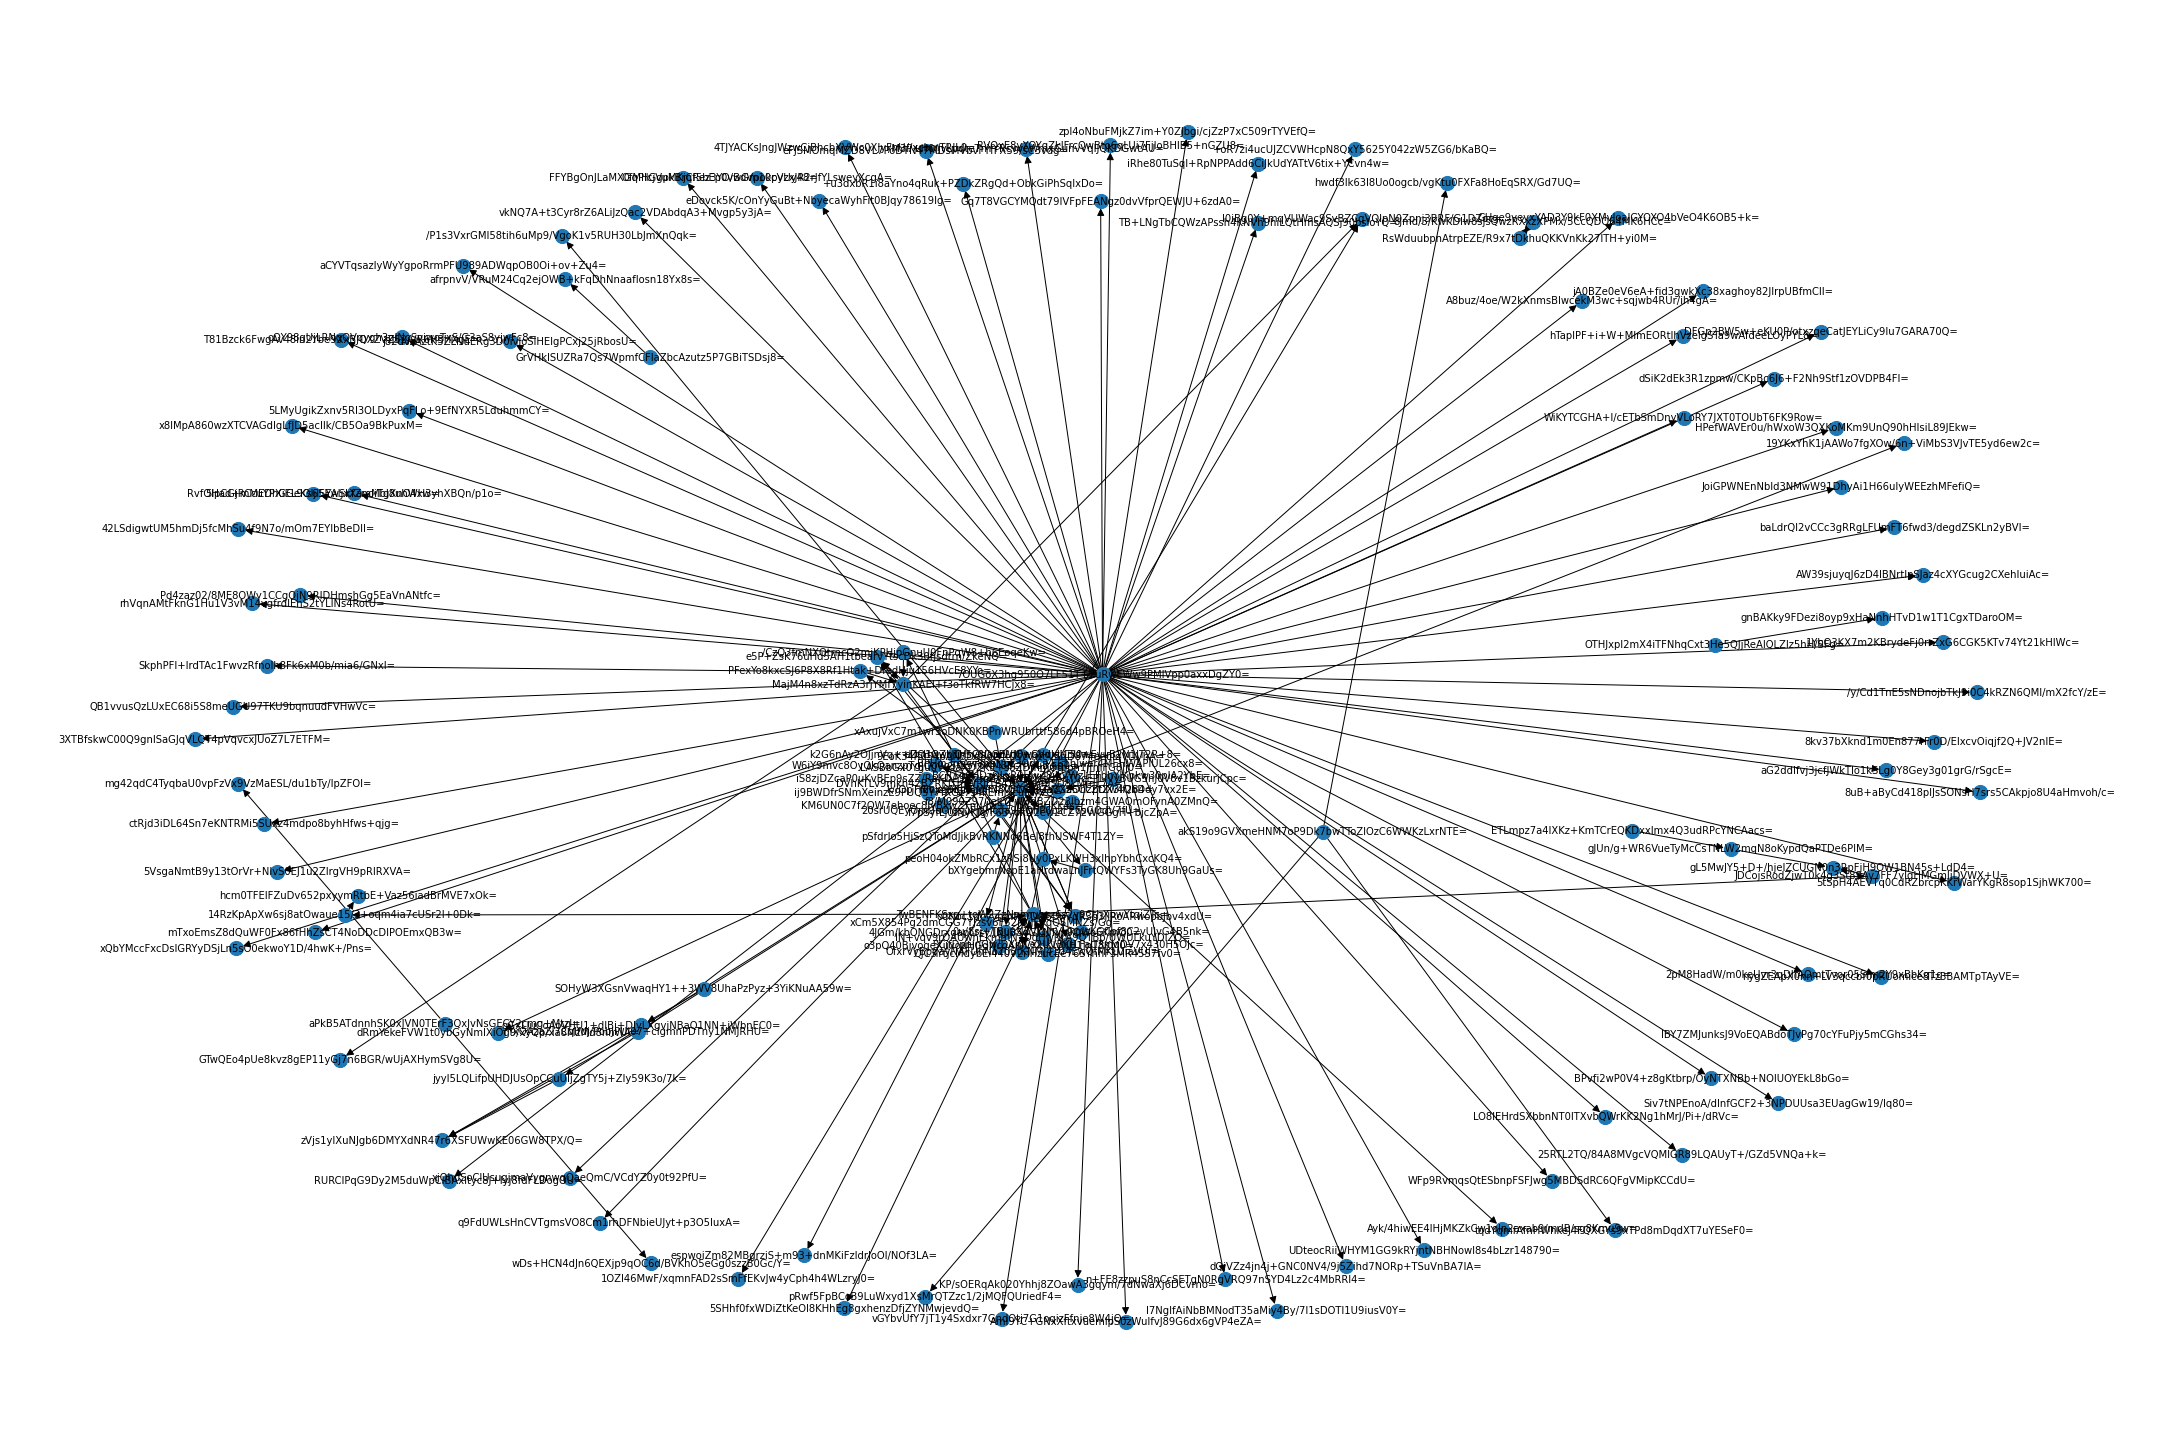

In [24]:
plt.figure(1, figsize=(30, 20))

pos = nx.spring_layout(nxGraph)
nx.draw(nxGraph, with_labels=True, arrowsize=15, node_size=200, pos=pos, font_size=10)
plt.show()

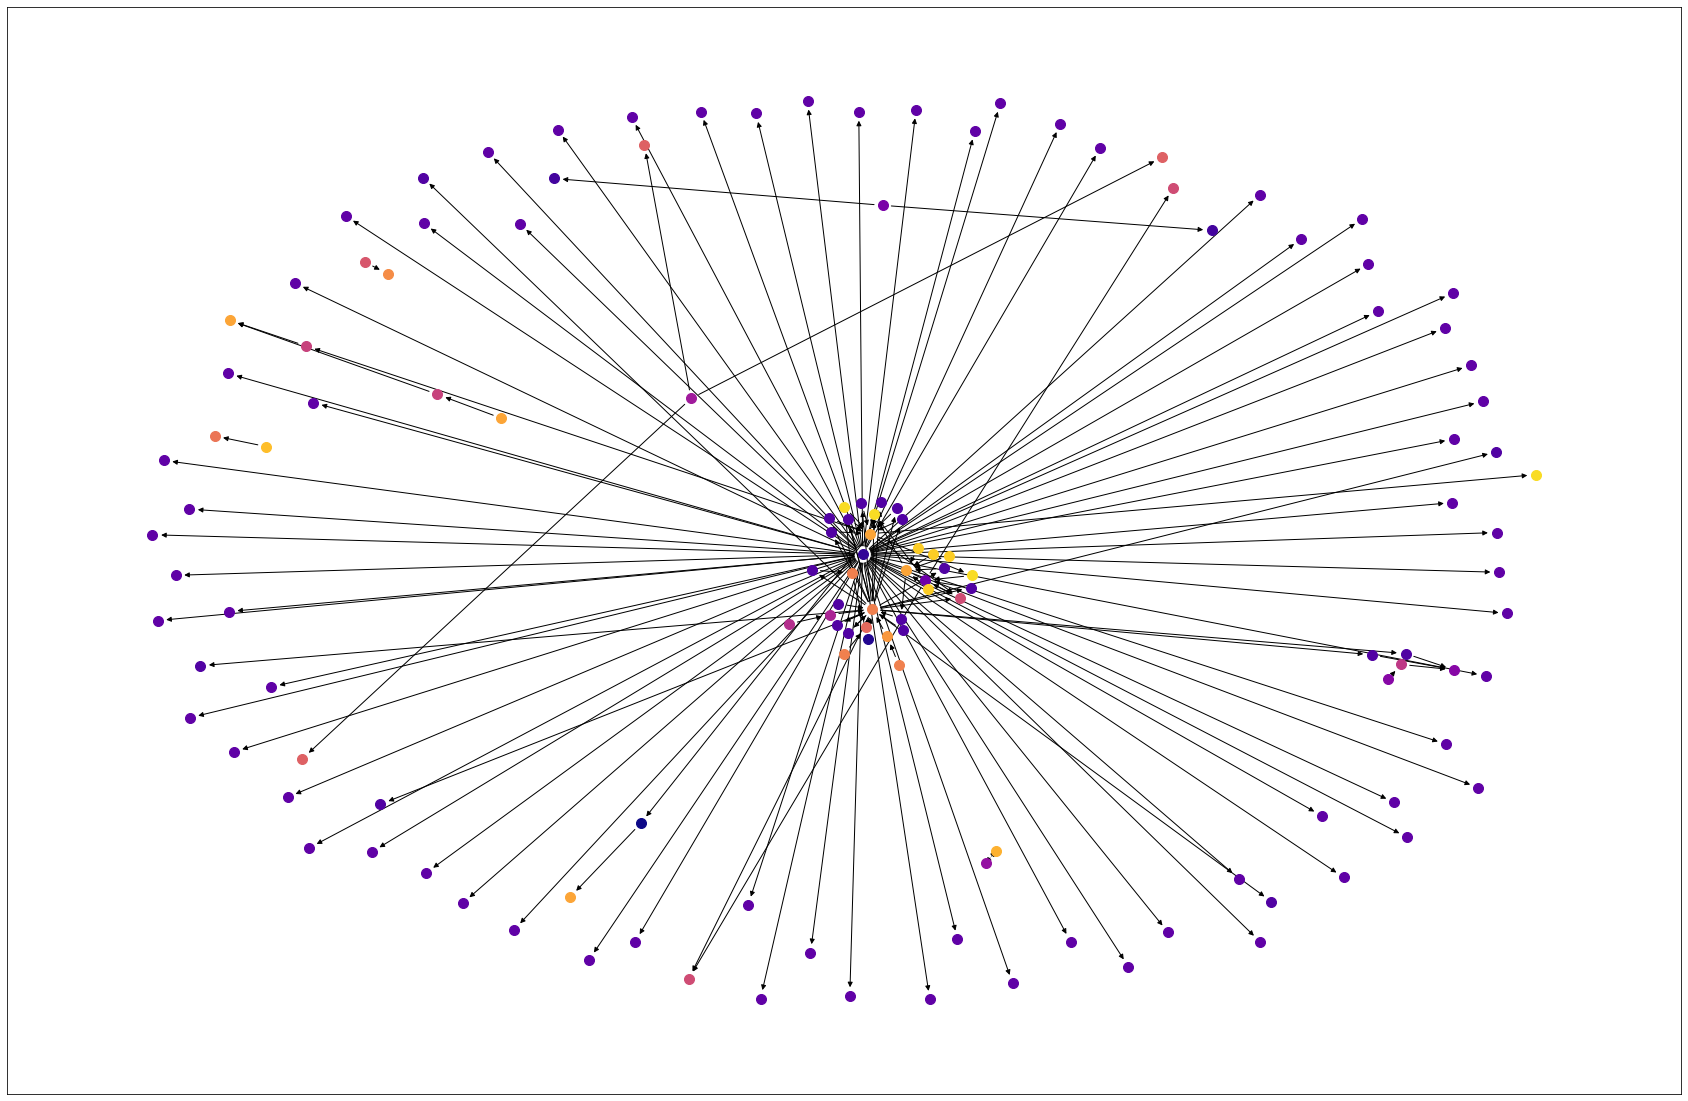

In [25]:
plt.figure(1, figsize=(30, 20))

colors = [mpt.colors.rgb2hex(c) for c in plt.get_cmap(name='plasma', lut=30).colors]
pos = nx.spring_layout(nxGraph)

nxVertices = commsDf.collect()
for i in range(len(nxVertices)):
    vertices = nxVertices[i][1]
    nx.draw_networkx_nodes(nxGraph, pos, node_color=colors[i], nodelist=nxVertices[i][1], node_size=100)
    
nx.draw_networkx_edges(nxGraph, pos)
plt.show()

### old tries

In [ ]:
# replace with read from datalake where data is not in json
# txn table to find all transactions between them
dfTxnTable = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "txn") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load() \
    .limit(1000)

# account table to determine which accounts have received rewards
dfAccounts2 = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "account") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load() \
    .limit(1000)

dfTxnTable.show()
dfAccounts2.show()

In [ ]:
dfTxnTable.where(dfTxn.TXN_SND == "7OUGoX3hg950O7LF51T+7uRwEWw9PMlVpp0axxDgZY0=").count()

In [ ]:
print(dfAccounts2.dtypes)

In [ ]:
dfAccounts2 = dfAccounts2.withColumn("addr", base64(col("addr")))

In [ ]:
dfAccounts2.show()

In [ ]:
dfTxn = dfTxnTable.select("txn")
dfTxn.show()
row = dfTxn.first()
print(row)

In [ ]:
from pyspark.sql.types import  *
from pyspark.sql.functions import *

In [ ]:
algorandTransactionSchema = StructType([
    StructField("rs", LongType()),
    StructField("sig", StringType()),
    StructField("txn", StructType()),
])

In [ ]:
test = dfTxn.select(from_json(dfTxn.txn, algorandTransactionSchema))

In [ ]:
test.collect()

In [ ]:
spark.stop()